In [1]:
import imageio
import math
import matplotlib.pyplot as plt
import numpy as np
import os 
from scipy.stats import norm
from scipy import signal
import scipy.optimize as optimize
import scipy.fftpack as fftpack
%matplotlib inline

In [2]:
def crop_horizontal(image, leftcols, rightcols):
    length = image.shape[1]
    new_image = image[:, leftcols:length-rightcols]
    return new_image

In [3]:
def find_offset(row, estimate):
    first_in = np.argwhere(row > estimate)[0]
    flipped_row = row[::-1]
    second_in = np.argwhere(flipped_row > estimate)[0]
    offset = np.nanmean(row[first_in[0]:row.shape[0] - second_in[0]])
    return offset

In [4]:
calibration_images = ['B', 'C', 'D', 'E', 'F', 'A', 'N', 'H', 'G', 'I', 'J', 'K', 'L', 'M']
actual_ods = np.array([.078, .107, .211, .358, .475, .56, .566, .572, .573, .664, .763, .879, 1.001, 1.143])

centered_sines = np.array(['5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']) # omitted 15
right_sines = np.array(['51', '61', '71', '81', '91', '101', '111', '121', '131', '141', '151']) # omitted 15

p2p_mods = np.array([.694, .666, .665, .666, .629, .626, .580, .579, .566, .444, .433])
freq_arr = np.array([.75, 1, 1.5, 2, 3, 4, 5, 6, 8, 10, 12])

In [5]:
def save_avg_arrs(image_list, crop_left, crop_right):
    avg_pixel_vals = []
    for name in image_list:
        image = get_cropped_image_arr(name, crop_left, crop_right)
        avg_pixel_vals.append(np.nanmean(image))
    avg_pixel_vals = np.array(avg_pixel_vals)
    np.save("avg_MTF_calibration_images_crop380.npy", avg_pixel_vals)

In [247]:
# save_avg_arrs(calibration_images, 380, 380)

In [6]:
def get_maxes(image_list, crop_left, crop_right):
    max_list = []
    for name in image_list:
        image = get_cropped_image_arr(name, crop_left, crop_right)
        max_list.append(np.amax(image))
    return max_list

In [7]:
def get_mins(image_list, crop_left, crop_right):
    min_list = []
    for name in image_list:
        image = get_cropped_image_arr(name, crop_left, crop_right)
        min_list.append(np.amin(image))
    return min_list

In [157]:
print(get_maxes(calibration_images, 380, 380))
print(get_mins(calibration_images, 380, 380))
print(get_maxes(centered_sines, 380, 380))
print(get_mins(right_sines, 380, 380))

[65504, 65504, 65504, 65504, 65504, 65504, 34080, 47040, 65504, 65504, 33728, 20512, 16224, 37696]
[20960, 15520, 16832, 8192, 11168, 7232, 11488, 11968, 9280, 9344, 2112, 5952, 4448, 2048]
[41344, 65504, 62560, 65504, 47872, 65504, 65504, 65504, 65504, 65504]
[960, 5088, 2048, 416, 1856, 2272, 2112, 1984, 448, 2464]


In [8]:
def cr_arr(sine_list, cal_list, ods, crop_left_sine, crop_right_sine, r):
    avg_image_arr = np.load("avg_MTF_calibration_images_crop380.npy")
    a2, a1, a0 = fit_od_curve(ods, avg_image_arr)
    crs = []
    for name in sine_list:
        image = imageio.imread(fr'sine_images/{name}.tiff')
        image = crop_horizontal(image, crop_left_sine, crop_right_sine)
        cr = contrast_ratio(image, a2, a1, a0, r)
        crs.append(cr)
    return np.array(crs)

In [9]:
# probably don't need
def calibration_array(image_names, known_ods, crop_cols):
    image_ods = []
    for name in image_names:
        image = imageio.imread(fr'sine_images/{name}.tiff')
        image = crop_horizontal(image, crop_cols, crop_cols)
        od = optical_density(image)
        image_ods.append(od)
    image_ods = np.array(image_ods)
    calibration = image_ods / known_ods
    return calibration

In [10]:
def optical_density(image, a3, a2, a1, a0):
    od = np.cbrt((image - a0 - a1 - a2) / a3) 
    return od

In [11]:
def pixel_val(od, p, m, o):
    val = o + (m / (10**(od / p)))
    return val

In [12]:
def poly_od(x, a3, a2, a1, a0):
    return a3*x**3 + a2*x**2 + a1*x + a0

In [13]:
def poly_od2(x, a2, a1, a0):
    return a2*x**2 + a1*x + a0

In [14]:
def exp_decay(t, A, K, C):
    return A * np.exp(K * t) + C

In [15]:
def fit_od_curve(ods, pixel_vals):
    guess = [1.4242606568625988, -5.679480526002312e-05, 0.0324280972941315]
    (a2, a1, a0), pcov = optimize.curve_fit(
        exp_decay, pixel_vals, ods, guess, maxfev=5000)
    return a2, a1, a0

In [16]:
def get_cropped_image_arr(name, crop_left, crop_right):
    image = imageio.imread(fr'sine_images/{name}.tiff')
    image = crop_horizontal(image, crop_left, crop_right)
    return image

In [17]:
def avg_images(image_list, crop_left, crop_right):
    avg_pixel_vals = []
    for name in image_list:
        image = get_cropped_image_arr(name, crop_left, crop_right)
        avg_pixel_vals.append(np.nanmean(image))
    avg_pixel_vals = np.array(avg_pixel_vals)
    return avg_pixel_vals

In [18]:
avg_image_arr = np.load("avg_MTF_calibration_images_crop380.npy")
print(avg_image_arr)
a2, a1, a0 = fit_od_curve(actual_ods, avg_image_arr)
print(a2, a1, a0)

[53251.46840533 49762.32305634 38961.01044145 27667.80015274
 21247.80820853 17755.12173578 17252.77716128 16965.54250919
 17179.3818258  13883.40870999 10883.63919902  8520.06810932
  6738.72804255  5132.33477509]
1.4241663563069356 -5.6764291282923414e-05 0.03236932517597061


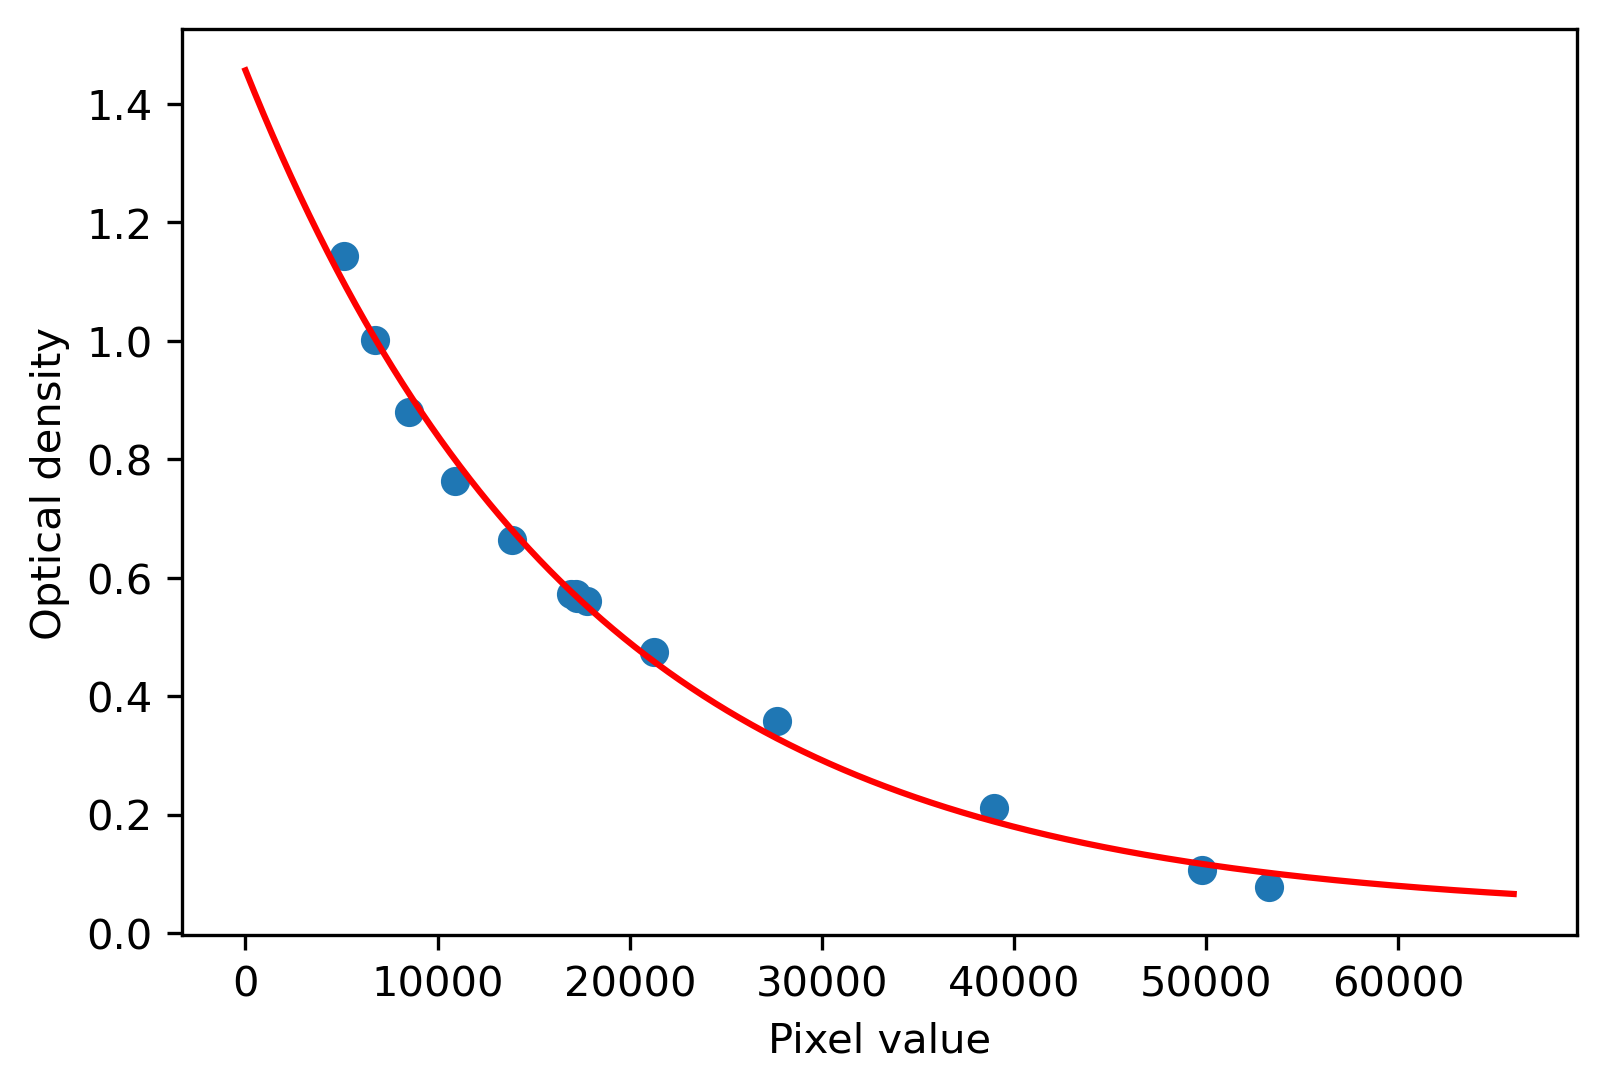

In [20]:
x = np.arange(0, 66000, .1)
plt.figure(dpi=300)
plt.xlabel("Pixel value")
plt.ylabel("Optical density")
plt.plot(x, exp_decay(x, a2, a1, a0), color='red')
plt.scatter(avg_image_arr, actual_ods)
plt.show()

In [235]:
 def sine(x, a1, a2, a3):
    return a1 * np.sin(a2 * x + a3)

In [236]:
# print(calibration_array(calibration_images, actual_ods, 375))

In [237]:
def fit_sine(row):
    pi = np.pi
    b_mid = np.nanmean(row)
    amp = (np.amax(row) - np.amin(row)) / 2
    offset = find_offset(row, b_mid)
    row -= offset

    N = xmax = row.shape[0]
    xReal = np.linspace(0, xmax, N)

    yhat = fftpack.rfft(row)
    idx = (yhat**2).argmax()
    freqs = fftpack.rfftfreq(N, d = (xReal[1]-xReal[0])/(2*pi))
    frequency = freqs[idx]

    amplitude = row.max()
    guess = [amp, frequency, 0.]
    (amplitude, frequency, phase), pcov = optimize.curve_fit(
        sine, xReal, row, guess, maxfev=5000)
    fit = np.array(sine(xReal, amplitude, frequency, phase))
    return amplitude, offset, fit

In [273]:
def contrast_ratio(image, a2, a1, a0, r):
    contrast_ratios = []
    offsets = []
    heights = []
    i = 0
    while i < image.shape[0]:
        if i in range((image.shape[0] // 2) - r, (image.shape[0] // 2) + r):
            sine_ret = fit_sine(image[i].astype('float64'))
            height = sine_ret[0]
            offset = sine_ret[1]
            sine_fit = sine_ret[2]
            avg_max = height + offset
            avg_min = offset - height
#             max_t = avg_max
#             min_t = avg_min
            max_t = 10**(-1*exp_decay(avg_max, a2, a1, a0))
            min_t = 10**(-1*exp_decay(avg_min, a2, a1, a0))
            cr = (max_t - min_t) / (max_t + min_t)
            contrast_ratios.append(cr)
        i += 1
    contrast_ratios = np.array(contrast_ratios)
    avg_cr = np.nanmean(contrast_ratios)
    return avg_cr

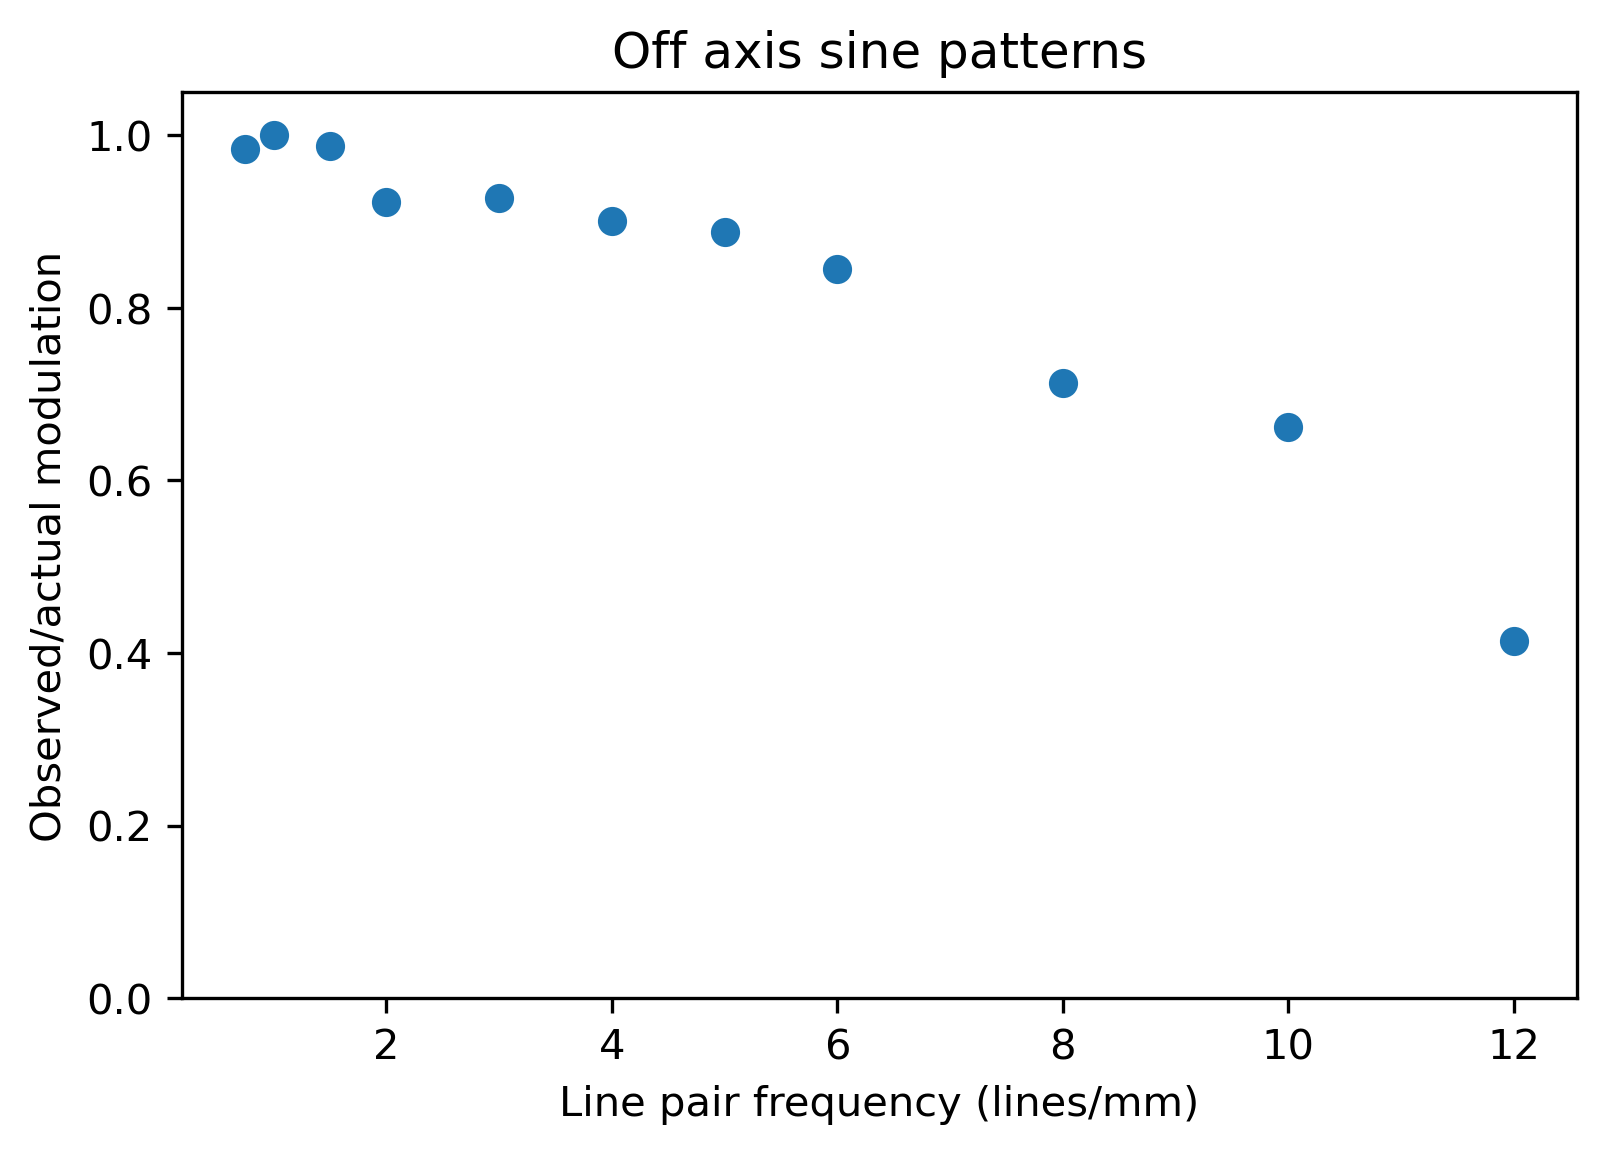

In [289]:
cr_array = np.abs(cr_arr(right_sines, calibration_images, actual_ods, 1980, 40, 35))
normalized_crs = (cr_array / p2p_mods)
normalized_crs = normalized_crs / np.amax(normalized_crs)
plt.figure(dpi=300)
plt.title("Off axis sine patterns")
plt.ylim([0,1.05])
plt.xlabel("Line pair frequency (lines/mm)")
plt.ylabel("Observed/actual modulation")
plt.scatter(freq_arr, normalized_crs)
plt.show()